In [8]:
import logging
import os
import sys
import shutil
import tempfile
import pandas as pd

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.networks.nets import resnet18
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.2.0
Numpy version: 1.26.0
Pytorch version: 2.1.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /root/miniconda3/envs/cmri/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.19.3
Pillow version: 10.0.1
Tensorboard version: 2.12.1
gdown version: 4.7.1
TorchVision version: 0.16.0
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.1.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-rec

In [2]:
df = pd.read_csv('Snapshot_tidy.csv')
df

,patients,"Sex (1=M, 2=F)",Age (years),SDMT,images
0,9001,2,35,35,/home/yw4196/Snapshot_T1_DeepLearning/9001_T1_...
1,9003,2,53,56,/home/yw4196/Snapshot_T1_DeepLearning/9003_T1_...
2,9004,2,52,54,/home/yw4196/Snapshot_T1_DeepLearning/9004_T1_...
3,9005,1,37,31,/home/yw4196/Snapshot_T1_DeepLearning/9005_T1_...
4,9006,2,39,38,/home/yw4196/Snapshot_T1_DeepLearning/9006_T1_...
...,...,...,...,...,...
120,9270,1,48,25,/home/yw4196/Snapshot_T1_DeepLearning/9270_T1_...
121,9278,2,33,63,/home/yw4196/Snapshot_T1_DeepLearning/9278_T1_...
122,9279,2,55,65,/home/yw4196/Snapshot_T1_DeepLearning/9279_T1_...
123,9286,1,37,49,/home/yw4196/Snapshot_T1_DeepLearning/9286_T1_...


In [3]:
images = df["images"].tolist()
labels = df["SDMT"].tolist()

In [4]:
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(),Resize((128, 128, 128)), RandRotate90()])

val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((128, 128, 128))])

check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)

check_loader = DataLoader(check_ds, batch_size=2, num_workers = 0, pin_memory=pin_memory)
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([2, 1, 128, 128, 128]) tensor([35, 56]) torch.Size([2])


In [5]:
train_ds = ImageDataset(image_files=images[:88], labels=labels[:88] , transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, num_workers =0, shuffle=True, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-37:], labels=labels[-37:] , transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, pin_memory=pin_memory)


<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([2, 1, 128, 128, 128]) tensor([21, 45]) torch.Size([2])


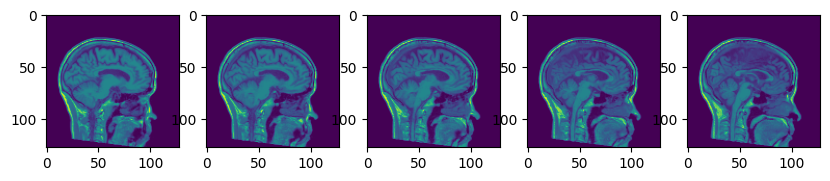

In [9]:
im, label = monai.utils.misc.first(train_loader)
print(type(im), im.shape, label, label.shape)
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(im[0, 0,59 + i,:])
    plt.gcf().set_size_inches(10, 10)
plt.show()

In [7]:
#from monai import model_constructor
net = resnet18(
    pretrained=False,
    spatial_dims=3,
    n_input_channels=1,
    num_classes=1  # Change the number of output classes to 1 for regression
)
net_dict = net.state_dict()
pretrain = torch.load("resnet_18_23dataset.pth")
pretrain['state_dict'] = {k.replace('module.', ''): v for k, v in pretrain['state_dict'].items()}
# #missing = tuple({k for k in net_dict.keys() if k not in pretrain['state_dict']})
# #logging.debug(f"missing in pretrained: {len(missing)}")
# #inside = tuple({k for k in pretrain['state_dict'] if k in net_dict.keys()})
# #logging.debug(f"inside pretrained: {len(inside)}")
# #unused = tuple({k for k in pretrain['state_dict'] if k not in net_dict.keys()})
# #logging.debug(f"unused pretrained: {len(unused)}")
# assert len(inside) > len(missing)
# assert len(inside) > len(unused)

pretrain['state_dict'] = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
net.load_state_dict(pretrain['state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['layer2.0.downsample.0.weight', 'layer2.0.downsample.0.bias', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.0.downsample.1.running_mean', 'layer2.0.downsample.1.running_var', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.0.bias', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.0.downsample.1.running_mean', 'layer3.0.downsample.1.running_var', 'layer4.0.downsample.0.weight', 'layer4.0.downsample.0.bias', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias', 'layer4.0.downsample.1.running_mean', 'layer4.0.downsample.1.running_var', 'fc.weight', 'fc.bias'], unexpected_keys=[])

In [12]:
from monai.networks.nets import Regressor
model = Regressor(in_shape=[1, 128, 128, 128], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)
model.to(device)
loss_function = torch.nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
loss_val = 0
#writer = SummaryWriter()
max_epochs = 4

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = torch.squeeze(model(inputs), 1)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        #writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

#         num_correct = 0.0
#         metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = torch.squeeze(model(val_images), 1)
                value = abs(val_outputs.cpu().numpy()-val_labels.cpu().numpy())
                loss_val += np.sum(value)
        metric = loss_val / len(val_ds)
        print(f"val_loss: {metric:.4f}")

#         metric = num_correct / metric_count
#         metric_values.append(metric)

#         if metric > best_metric:
#             best_metric = metric
#             best_metric_epoch = epoch + 1
#             torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
#             print("saved new best metric model")

#         print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
#         print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
#         writer.add_scalar("val_accuracy", metric, epoch + 1)

# print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
# writer.close()

----------
epoch 1/4
1/44, train_loss: 33.1118
2/44, train_loss: 28.9170
3/44, train_loss: 45.0264
4/44, train_loss: 40.5866
5/44, train_loss: 25.7611
6/44, train_loss: 10.9148
7/44, train_loss: 19.6321
8/44, train_loss: 7.7358
9/44, train_loss: 9.0511
10/44, train_loss: 22.1696
11/44, train_loss: 5.1750
12/44, train_loss: 3.9106
13/44, train_loss: 18.3927
14/44, train_loss: 7.7447
15/44, train_loss: 16.7219
16/44, train_loss: 16.6118
17/44, train_loss: 29.8425
18/44, train_loss: 22.2744
19/44, train_loss: 3.1089
20/44, train_loss: 6.3661
21/44, train_loss: 8.1487
22/44, train_loss: 9.7003
23/44, train_loss: 7.9930
24/44, train_loss: 8.9540
25/44, train_loss: 10.1837
26/44, train_loss: 24.9933
27/44, train_loss: 9.6486
28/44, train_loss: 13.9325
29/44, train_loss: 13.8925
30/44, train_loss: 21.4471
31/44, train_loss: 21.8426
32/44, train_loss: 7.2651
33/44, train_loss: 15.1398
34/44, train_loss: 20.5354
35/44, train_loss: 2.7411
36/44, train_loss: 26.2678
37/44, train_loss: 31.0072
38/

torch.save(model.state_dict(), "reg_MONAI_Snapshot_whole.pth")

In [24]:
state_dict = torch.load("reg_MONAI_Snapshot_whole.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [13]:
# create a validation data loader
test_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [14]:
# Get a random image and its corresponding label
img, label = get_next_im()


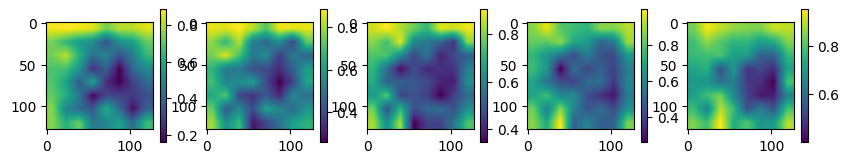

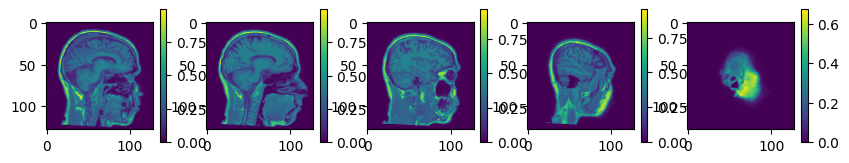

In [15]:
from monai.visualize import GradCAMpp
cam = GradCAMpp(nn_module=model, target_layers="net.layer_3")
result = cam(x=img)
a = 0
b = 0
d = 59

for i in range(0, 50, 10):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 10 + 1)
    im = plt.imshow(result[a, b, d + i, :].cpu().numpy())
    plt.colorbar(im)  # Add a colorbar for each image
    plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(0, 50, 10):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 10 + 1)
    im = plt.imshow(img[a, b, d + i, :].cpu().numpy())
    plt.colorbar(im)  # Add a colorbar for each image
    plt.gcf().set_size_inches(10, 10)
plt.show()